#Оценка качества изображений

**Постановка задачи**: Фотографии загружаемые поставщиками WB имеют разное качество: На одних может быть сложный фон, на каких-то фотографиях часть объекта не попала в кадр и.т.п. Для последующей работы с такими данными, например при использовании алгоритмов поиска по фото надо знать типs дефектов/овособенностей которые присутствуют на изображении.

<img src ="https://ml.gan4x4.ru/wb/quality/content/samples.png" width="800">


Всего 6 типов особенностей:  

* untidy,
* angle-composition,
* background,
* crop,
* text,
* multiple-objects

и один класс для изображений без дефектов
* good-image.

При этом изображение может содержать несколько видов дефектов.


Задача:

Требуется создать модель которая будет определять список дефектов для для изображения.

# Данные

По [ссылке](https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip) доступен архив содержащий 5000 изображений и разметку.

Оригинальные изображения имели размер 900x1200 в датасете их разрешение уменьшено вдвое. Кроме изображений в архиве находиться csv файл c разметкой.
В первой колонке имя файла с изображением (без расширения), в остальных колонках названия классов к которым относиться изображение:

```
  18715,text,multiple-objects,,
  5259,text,background,,
  8932,background,,,
  ...

```

# Порядок выполнения задания

Задание рекомендуется выполнять по шагам:

1. Познакомьтесь с данными
2. Выберите метрику для оценки результата
3. Проведите анализ состояния вопроса, изучите существующие модели которые можно использовать для решения задачи
4. Проведите EDA, опишите особенности данных и проблемы которые они могут за собой повлечь
5. Подготовьте данные для обучения
6. Выберите baseline модель, оцените качество её работы на данном датасете.
7. Попробуйте улучшить значение метрики используя другую модель. Возможно обучив/дообучив ее.
8. Оцените быстродействие выбранной модели
9. Дайте оценку полученному результату.


**Важно!**

Блокнот должен содержать весь необходимый код для запуска финальной модели. Если для запуска требуется подгрузка весов, все ссылки длжны работать не только в вашем аккаунте но и в аккаунте преподавателя.

## Анализ данных (EDA)

In [4]:
# !wget https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip
# !unzip student_5000.zip

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import hamming_loss, accuracy_score, f1_score

import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from PIL import Image
import os

from torchvision.models import resnet50, ResNet50_Weights

In [7]:
defects = ['untidy',
'angle-composition',
'background',
'crop',
'text',
'multiple-objects']

num_classes = len(defects)

df = pd.read_csv("labels.csv", names=["image_id", *range(1,5)])

df['defects'] = df.iloc[:, 1:].apply(lambda row: set(row), axis=1) # type: ignore

for defect_name in defects:
    df[defect_name] = df['defects'].apply(lambda x: 1 if defect_name in x else 0)

df = df[['image_id', *defects]]

df

,image_id,untidy,angle-composition,background,crop,text,multiple-objects
0,18715,0,0,0,0,1,1
1,5259,0,0,1,0,1,0
2,8932,0,0,1,0,0,0
3,6070,0,0,0,0,0,0
4,13889,0,0,0,0,0,0
...,...,...,...,...,...,...,...
4995,12027,0,0,0,0,1,0
4996,23246,0,0,0,0,0,0
4997,1534,0,0,0,0,0,0
4998,10381,0,0,1,0,0,0


In [8]:
df['defects_code'] = df.iloc[:, 1:].apply(lambda row: ''.join(map(str, row)), axis=1)
df

,image_id,untidy,angle-composition,background,crop,text,multiple-objects,defects_code
0,18715,0,0,0,0,1,1,000011
1,5259,0,0,1,0,1,0,001010
2,8932,0,0,1,0,0,0,001000
3,6070,0,0,0,0,0,0,000000
4,13889,0,0,0,0,0,0,000000
...,...,...,...,...,...,...,...,...
4995,12027,0,0,0,0,1,0,000010
4996,23246,0,0,0,0,0,0,000000
4997,1534,0,0,0,0,0,0,000000
4998,10381,0,0,1,0,0,0,001000


In [9]:
class_counts = df.iloc[:, 1:-1].sum()
print("Баланс меток:")
print(class_counts)


Баланс меток:
untidy               137
angle-composition    164
background           918
crop                 194
text                 959
multiple-objects     133
dtype: int64


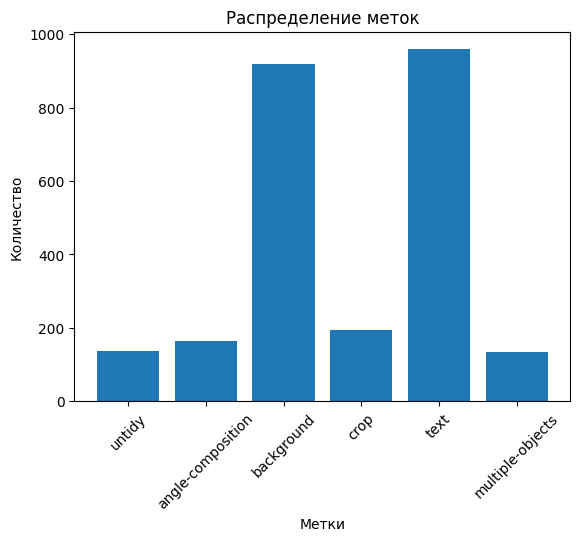

In [10]:
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Метки')
plt.ylabel('Количество')
plt.title('Распределение меток')
plt.xticks(rotation=45)
plt.show()


Присутствует дисбаланс меток

<Axes: xlabel='defects_code'>

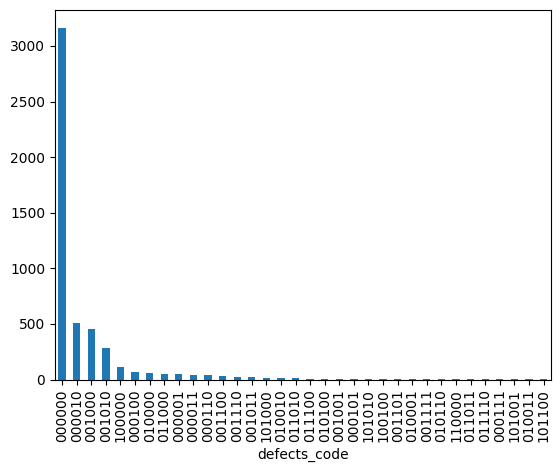

In [11]:
df['defects_code'].value_counts().plot(kind='bar')

In [12]:
image_folder = 'images'

image_paths = [os.path.join(image_folder, str(image_id)+'.jpg') for image_id in df['image_id']]
labels = df.iloc[:, 1:-1].to_numpy()

In [13]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = torch.FloatTensor(self.labels[index])

        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageDataset(image_paths, labels, transform=transform)

batch_size = 1

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

['untidy']


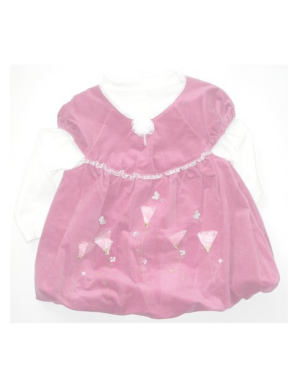

['angle-composition', 'text']


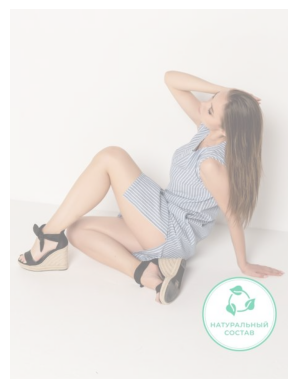

['background', 'crop']


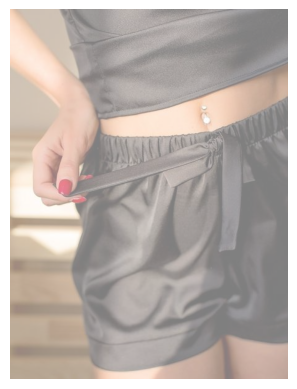

['background', 'crop']


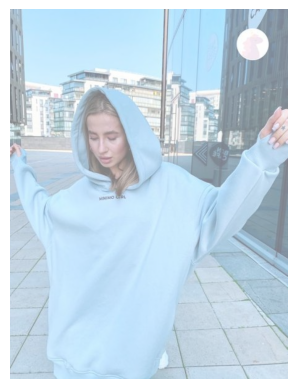

['text']


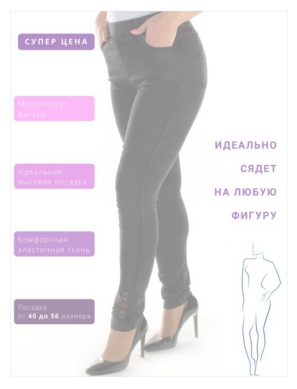

['multiple-objects']


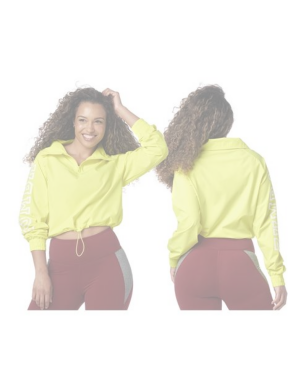

In [ ]:
defect_index = 0
for image, label in dataloader:
    batch_defects = [defect for defect, label in zip(defects,label[0]) if label == 1]

    if label[0][defect_index] == 1:
        print(batch_defects if batch_defects else 'good-image')
        plt.imshow(image[0].permute(1, 2, 0) / 2 + 0.5)
        plt.axis('off')
        plt.show()
        defect_index+=1

    if defect_index == 6:
        break

# Метрики

Для оценки модели я выбрал несколько метрик, таких как: hamming score, accuracy и f1 score, но в конечном счете ориентировался на f1 score.

In [15]:
sigmoid = nn.Sigmoid()

def calculate_metrics(model, loader, device='cuda'):
    model.to(device)
    model.eval()

    hamming_scores = []
    accuracy_scores = []
    f1_scores_by_label = []
    f1_scores_weighted = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).data.cpu()

            probabilities = sigmoid(outputs)

            predicted = (np.array(probabilities) >= 0.5).astype(int)

            batch_hamming_score = 1 - hamming_loss(labels.cpu(), predicted)
            batch_accuracy = accuracy_score(labels.cpu(), predicted)
            batch_f1_score_by_label = f1_score(labels.cpu(), predicted, average=None, zero_division=1)
            batch_weighted_f1_score = f1_score(labels.cpu(), predicted, average='weighted', zero_division=1)

            hamming_scores.append(batch_hamming_score)
            accuracy_scores.append(batch_accuracy)
            f1_scores_by_label.append(batch_f1_score_by_label)
            f1_scores_weighted.append(batch_weighted_f1_score)

    return {'hamming_score': np.mean(hamming_scores),
            'accuracy': np.mean(accuracy_scores),
            'f1_score_by_label': np.mean(f1_scores_by_label, axis=0),
            'f1_score_weighted': np.mean(f1_scores_weighted),}

In [16]:
def make_few_graphs(metrics, epoch):
    epochs = list(range(1, epoch+2))
    nrows = len(metrics) // 3
    ncols = len(metrics) // nrows
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,nrows*4), constrained_layout=True)
    for graph_index, (score_name, score_dict) in enumerate(metrics.items()):
        for split_name, score_array in score_dict.items():
            if nrows>=2:
               index_tuple = (graph_index//3, graph_index%3)
            else:
               index_tuple = graph_index

            axs[index_tuple].plot(epochs, score_array, label=split_name)
            axs[index_tuple].set_title(score_name)
            axs[index_tuple].set_xlabel('Epoch')
            axs[index_tuple].set_ylabel('Score')
            axs[index_tuple].set_ylim(0, 1)
            axs[index_tuple].legend()

    plt.show()

## Baseline

In [18]:
image_folder = 'images'

image_paths = [os.path.join(image_folder, str(image_id)+'.jpg') for image_id in df['image_id']]
labels = df.iloc[:, 1:-1].to_numpy()

In [19]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = torch.FloatTensor(self.labels[index])

        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [20]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_aug = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #imagenet mean std
])


train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=101)

train_dataset = ImageDataset(train_paths, train_labels, transform=transform_aug)
val_dataset = ImageDataset(val_paths, val_labels, transform=transform)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #sampler
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [21]:
class CNNModel_ver2(nn.Module): #224x224
    def __init__(self, num_classes):
        super(CNNModel_ver2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(p=0.5),

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [22]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device='cuda'):
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    split_names = ['train', 'val']

    hamming_scores = {'train': [],
                      'val': []}

    accuracy_scores = {'train': [],
                        'val': []}

    f1_scores_by_label = {'train': [],
                        'val': []}

    f1_scores_weighted = {'train': [],
                        'val': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, f"Epoch [{epoch+1}/{num_epochs}]"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)


        epoch_loss = running_loss / len(train_loader.dataset)

        train_metrics = calculate_metrics(model, train_loader)
        val_metrics = calculate_metrics(model, val_loader)

        metrics = {'train': train_metrics,
                   'val': val_metrics}

        for split_name in split_names:
            hamming_scores[split_name].append(metrics[split_name]['hamming_score'])

            f1_scores_by_label[split_name].append(metrics[split_name]['f1_score_by_label'])

            f1_scores_weighted[split_name].append(metrics[split_name]['f1_score_weighted'])

            accuracy_scores[split_name].append(metrics[split_name]['accuracy'])

        clear_output()

        last_metrics = {'Hamming score': {split_name: hamming_scores[split_name] for split_name in split_names},
                        'Accuracy score': {split_name: accuracy_scores[split_name] for split_name in split_names},
                        'Mean F1 score': {split_name: f1_scores_weighted[split_name] for split_name in split_names},}

        make_few_graphs(last_metrics, epoch)

        last_f1_metric_by_label = {f'{defect_name}-label F1 score': \
                                        {split_name: np.array(f1_scores_by_label[split_name])[:, defect_index] \
                                         for split_name in split_names} \
                                   for defect_index, defect_name in enumerate(defects)}


        make_few_graphs(last_f1_metric_by_label, epoch)


        print(f"Loss: {epoch_loss:.4f}")
        print(f"Train Hamming Score: {metrics['train']['hamming_score']:.4f}, Validation Hamming Score: {metrics['val']['hamming_score']:.4f}")
        print(f"Train Accuracy Score: {metrics['train']['accuracy']:.4f}, Validation Accuracy Score: {metrics['val']['accuracy']:.4f}")
        print(f"Train F1 Weighted Score: {metrics['train']['f1_score_weighted']:.4f}, Validation Weighted Score: {metrics['val']['f1_score_weighted']:.4f}")

        last_f1_score = {defect_name: {split_name: round(metrics[split_name]['f1_score_by_label'][index], 4) for split_name in split_names}for index, defect_name in enumerate(defects)}
        print(f"F1-score:")
        print(pd.DataFrame(last_f1_score))

        print()

        print(f"Best Validation Hamming Score: {max(hamming_scores['val']):.4f}")
        print(f"Best Validation Accuracy Score: {max(accuracy_scores['val']):.4f}")
        best_f1_scores_by_label_val = {defect_name: round(f1_scores_by_label['val'][np.argmax(np.sum(f1_scores_by_label['val'], axis=1))][index], 4) for index, defect_name in enumerate(defects)}

        print(f"Best Val Mean F1-score {round(max(f1_scores_weighted['val']), 4)}")
        print(f"Best Val F1-score")
        print(pd.DataFrame(best_f1_scores_by_label_val, index=['val']))


    print('Обучение завершено')

    best_metrics_values = {'hamming_score': round(max(hamming_scores['val']), 4),
                           'f1_score': round(max(f1_scores_weighted['val']), 4),
                           'accuracy':  round(max(accuracy_scores['val']), 4),}

    torch.save(model.state_dict(), f"{model.__class__.__name__}_hamming_score_{best_metrics_values['hamming_score']}_{datetime.now().strftime('%d-%m %H-%M')}.pth")

    return model, best_metrics_values

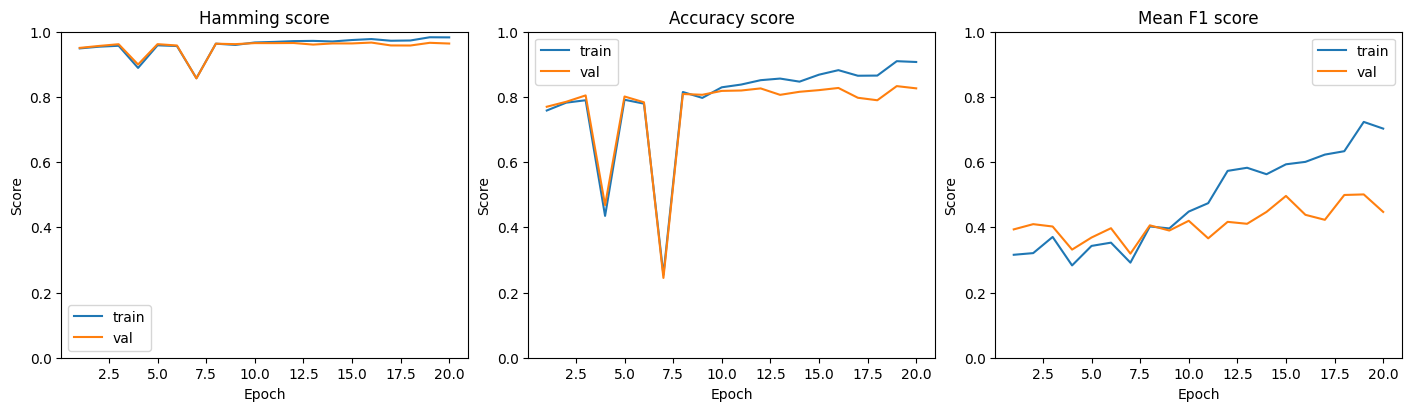

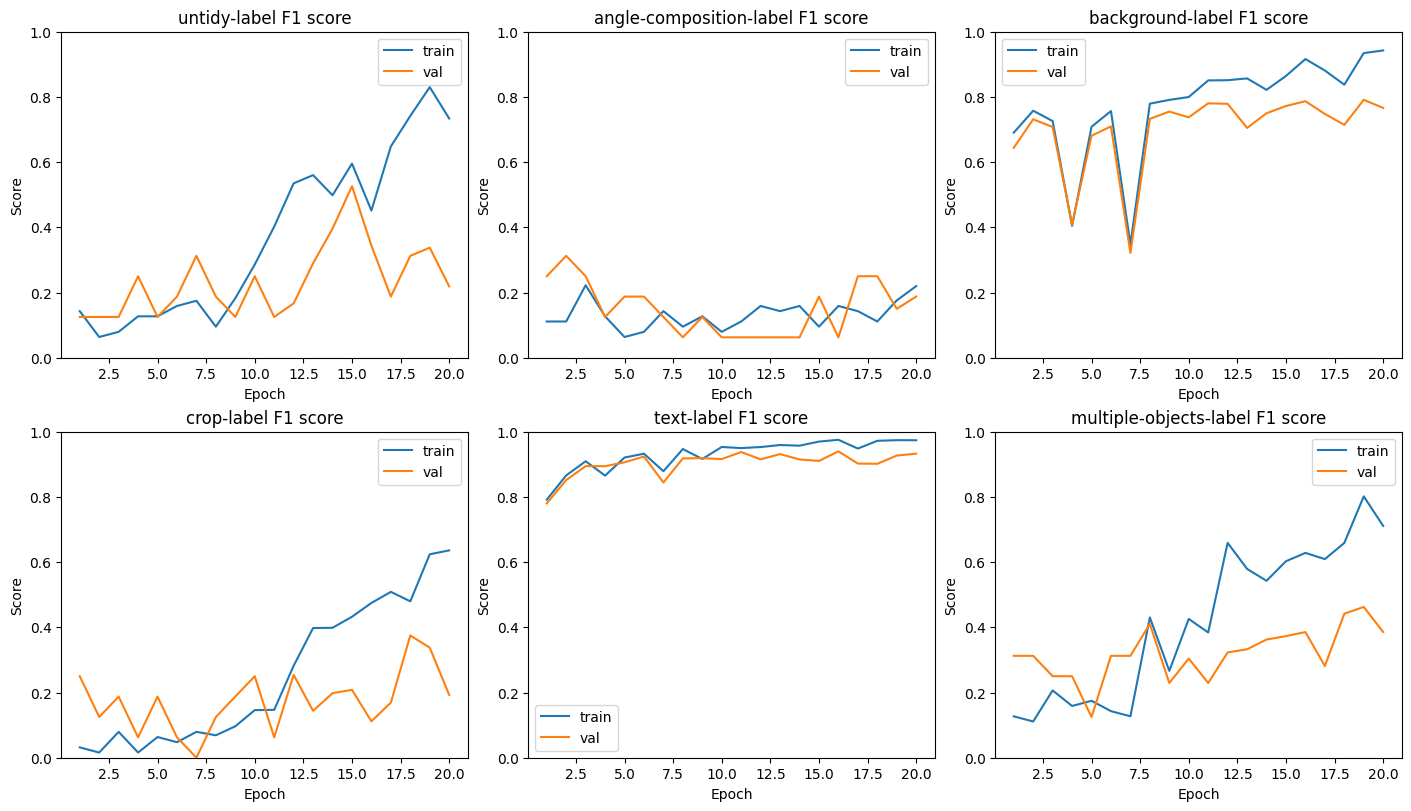

Loss: 0.0629
Train Hamming Score: 0.9825, Validation Hamming Score: 0.9636
Train Accuracy Score: 0.9070, Validation Accuracy Score: 0.8262
F1-score:
       untidy  angle-composition  background    crop    text  multiple-objects
train  0.7336             0.2197      0.9424  0.6359  0.9737            0.7109
val    0.2188             0.1875      0.7661  0.1927  0.9326            0.3854

Best Validation Hamming Score: 0.9666
Best Validation Accuracy Score: 0.8330
Best Val F1-score
     untidy  angle-composition  background    crop    text  multiple-objects
val  0.3375               0.15      0.7909  0.3375  0.9267            0.4625
Best Val Mean F1-score 0.5008
Обучение завершено


In [ ]:
model, metrics = train_model(CNNModel_ver2(num_classes), train_dataloader, val_dataloader, num_epochs=20)


## Решение

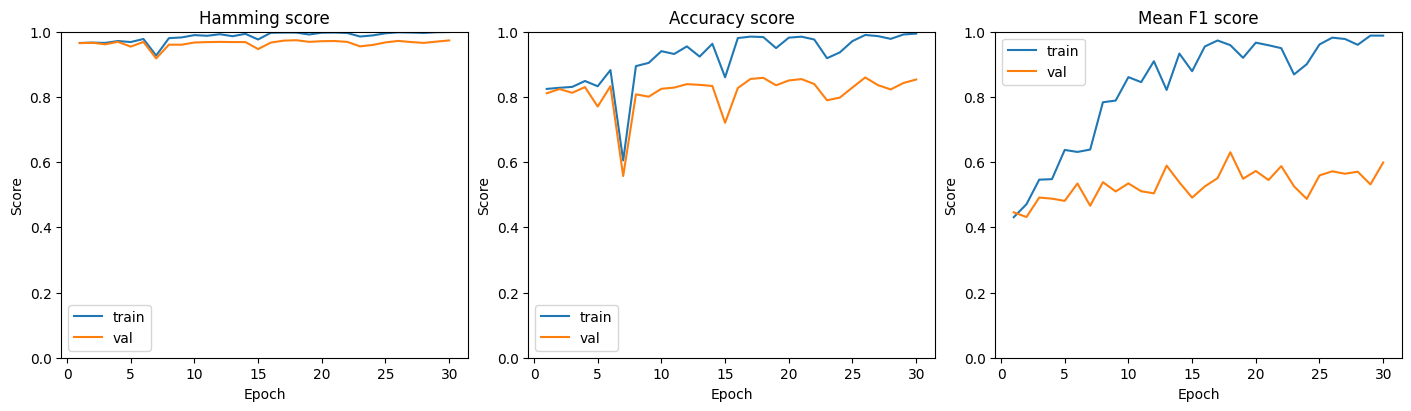

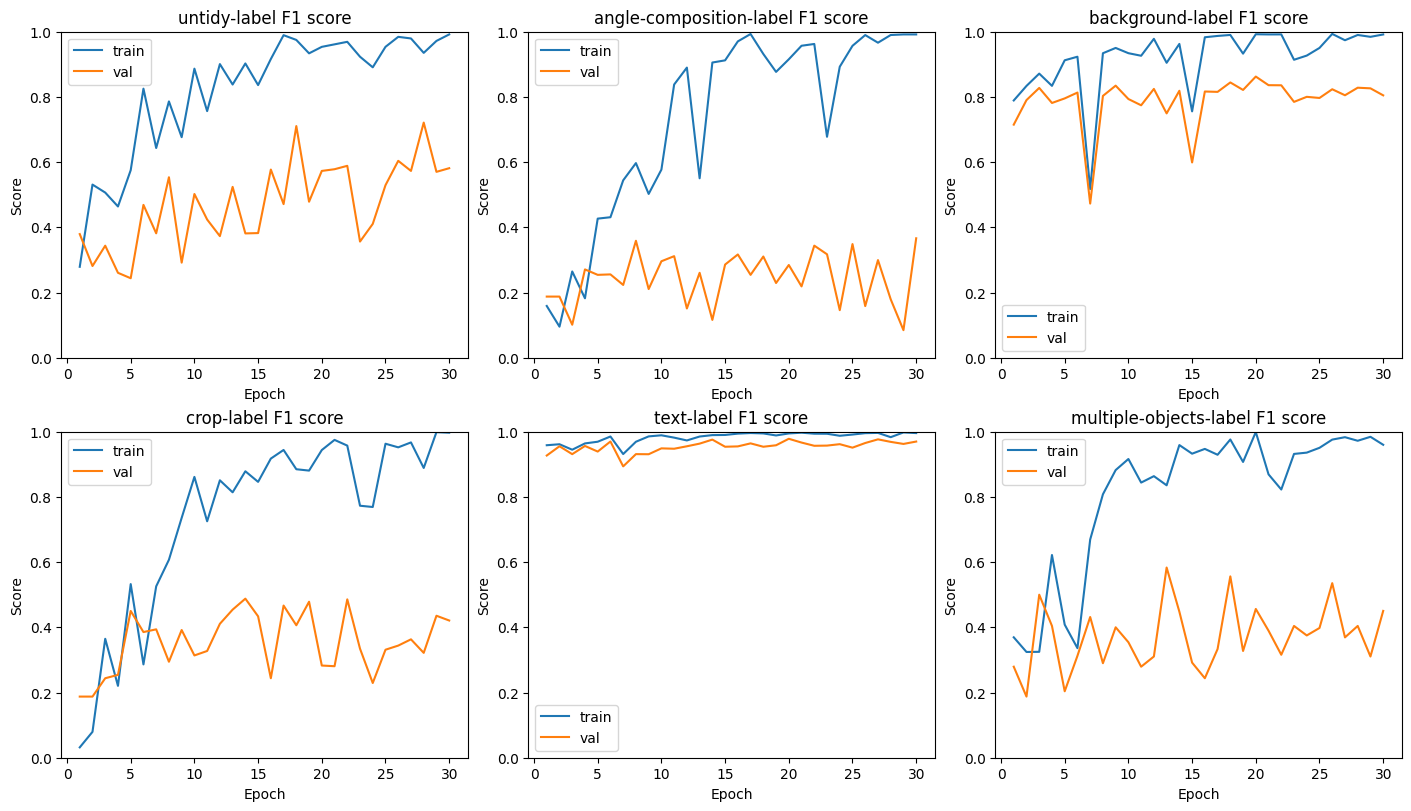

Loss: 0.0043
Train Hamming Score: 0.9989, Validation Hamming Score: 0.9731
Train Accuracy Score: 0.9940, Validation Accuracy Score: 0.8533
F1-score:
       untidy  angle-composition  background    crop    text  multiple-objects
train  0.9915             0.9915      0.9914  0.9968  0.9957            0.9598
val    0.5812             0.3663      0.8047  0.4208  0.9697            0.4503

Best Validation Hamming Score: 0.9738
Best Validation Accuracy Score: 0.8596
Best Val Mean F1-score 0.6302
Best Val F1-score
     untidy  angle-composition  background    crop    text  multiple-objects
val  0.7104             0.3104      0.8443  0.4062  0.9538            0.5562
Обучение завершено


In [ ]:
pretrained_model = resnet50(weights=ResNet50_Weights.DEFAULT)

pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

pretrained_model, metrics = train_model(pretrained_model, train_dataloader, val_dataloader, num_epochs=30, learning_rate=0.001)

Как видно из графиков, модель хорошо справляется с классификацией изображений с текстом и плохим фоном, но хуже классифицирует изображения с плохим углом, обрезкой, несколькими объектами и неопрятностью.

## Оценка результата

Модель хорошо справляется с классификацией дефектов, но в спорных моментах ошибается.



Правильный ответ: untidy
Ответ модели: good-image


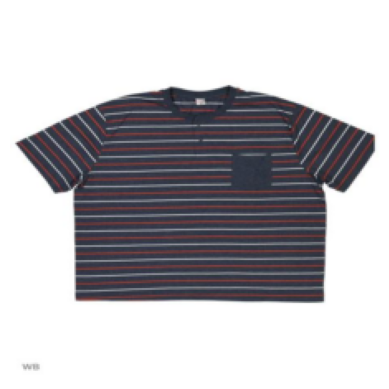

Правильный ответ: angle-composition,background
Ответ модели: angle-composition


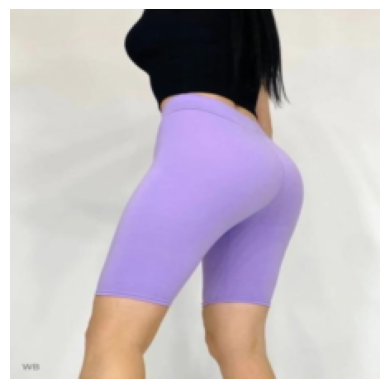

Правильный ответ: background
Ответ модели: background


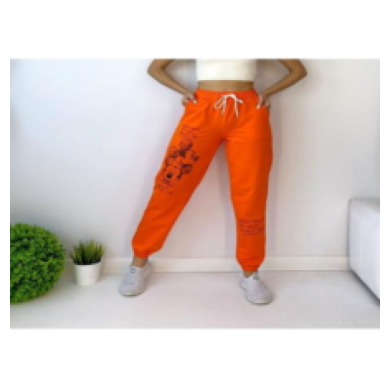

Правильный ответ: background,crop,text
Ответ модели: background,text


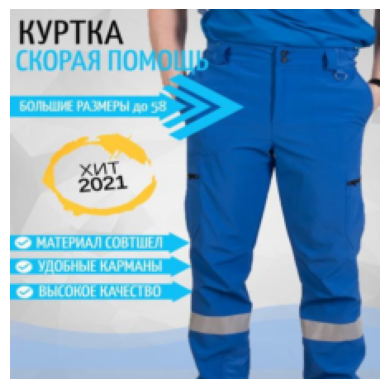

Правильный ответ: text
Ответ модели: background,text


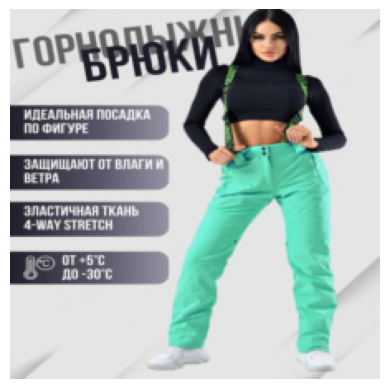

Правильный ответ: multiple-objects
Ответ модели: good-image


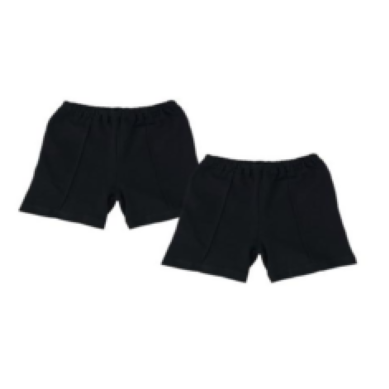

In [ ]:
def show_model_works(model, dataset, num_samples=1, device='cuda'):
    model.to(device)
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)

    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).data.cpu()

            probabilities = sigmoid(outputs)

            predicted = (np.array(probabilities) >= 0.5).astype(int)

            defect_index = 0
            for i in range(num_samples):
                true_labels = [defect for defect, label in zip(defects, labels[i]) if label == 1]
                model_pred = [defect for defect, label in zip(defects, predicted[i]) if label == 1]
                if labels[i][defect_index] == 1:
                    print('Правильный ответ: ' + (','.join(true_labels) if true_labels else 'good-image'))
                    print('Ответ модели: ' + (','.join(model_pred) if model_pred else 'good-image'))
                    plt.imshow(inputs[i].cpu().permute(1, 2, 0) / 2 + 0.5)
                    plt.axis('off')
                    plt.show()
                    defect_index+=1

                if defect_index == 6:
                    break

            break

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('resnet50_hamming_0.9731.pth'))

show_model_works(model, val_dataset, num_samples=100)

Правильный ответ: untidy
Ответ модели: good-image


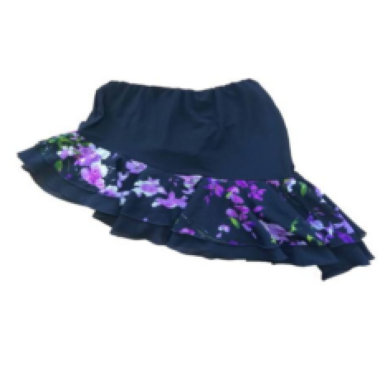

Правильный ответ: angle-composition,background
Ответ модели: background


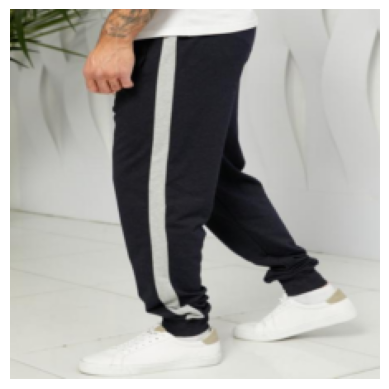

Правильный ответ: background,text
Ответ модели: background,text


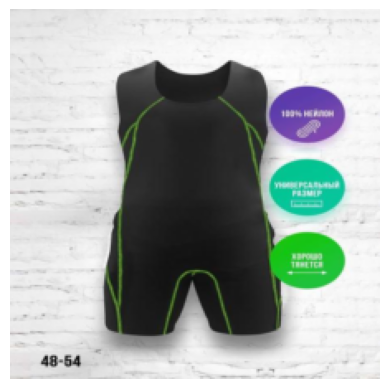

Оценка быстродействия модели показала среднее время выполнения 16.5 миллисекунд на один проход через данные. Это время может быть приемлемым для многих приложений, но для более критичных задач может потребоваться дополнительная оптимизация.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
model.eval()

In [ ]:
%%timeit
with torch.no_grad():
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).data.cpu()

        probabilities = sigmoid(outputs)

        predicted = (np.array(probabilities) >= 0.5).astype(int)
        break

16.5 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Вывод



# Тестовый блок для проверки

Поместите сюда весь необходимый код для тестирования вашей модели на новых данных. Убедитесь что

- Импортируются все библиотеки и классы
- Подгружабтся веса с внешних ресурсов
- Происходит рассчет метрик
...

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import hamming_loss, accuracy_score, f1_score

import pandas as pd

import os

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet50

from PIL import Image


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gdown

In [2]:
!wget --no-check-certificate -O weights.zip 'https://downloader.disk.yandex.ru/disk/8ff5607de602c5530d539e31231baceb1e04111f40fd65545b951f7f2b8cdb2c/6693cde6/VvYHV0oK_DxmKnBjUYxFsEio8pCaROjRqId9tKZqTb1GVQGxbMJ65XPbP3VRHDgo1BSnfgKDwFvOzpxk6M7-Iw%3D%3D?uid=0&filename=model_weights.zip&disposition=attachment&hash=g9wdcgWv1EQK1GW7/9mEmNVYWq9A8ZNULQk8aLop8RxutPtuWdQvX0H81pcFZO74q/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=334943529&fsize=87608754&hid=5a059d8d0df4e1ed486fa2a34e6fa0c7&media_type=compressed&tknv=v2'
!unzip weights.zip

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"filename" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"disposition" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"hash" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"limit" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"content_type" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"owner_uid" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"fsize" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"hid" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"media_type" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"tknv" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [ ]:
from google.colab import drive
drive.mount('/content/yourdata')

Mounted at /content/drive


In [ ]:
main_folder = '/content/yourdata'

data_folder = os.path.join(main_folder, '5000')
image_folder = os.path.join(data_folder,'images')
labels_csv = os.path.join(data_folder,'5000.csv')
weights_path = os.path.join(main_folder,'resnet50_hamming_0.9731.pth')

In [ ]:
defects = ['untidy',
'angle-composition',
'background',
'crop',
'text',
'multiple-objects']

num_classes = len(defects)

df = pd.read_csv(labels_csv, names=["image_id", *range(1,5)])

df['defects'] = df.iloc[:, 1:].apply(lambda row: set(row), axis=1) # type: ignore

for defect_name in defects:
    df[defect_name] = df['defects'].apply(lambda x: 1 if defect_name in x else 0)

df = df[['image_id', *defects]]

image_paths = [os.path.join(image_folder, str(image_id)+'.jpg') for image_id in df['image_id']]

labels = df.iloc[:, 1:].to_numpy()

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = torch.FloatTensor(self.labels[index])

        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #надо нормально рассчитать среднее и отклонение
])

dataset = ImageDataset(image_paths, labels, transform=transform)

batch_size = 64

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
sigmoid = nn.Sigmoid()

def calculate_metrics(model, loader, device='cuda'):
    model.to(device)
    model.eval()

    hamming_scores = []
    accuracy_scores = []
    f1_scores_by_label = []
    f1_scores_weighted = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).data.cpu()

            probabilities = sigmoid(outputs)

            predicted = (np.array(probabilities) >= 0.5).astype(int)

            batch_hamming_score = 1 - hamming_loss(labels.cpu(), predicted)
            batch_accuracy = accuracy_score(labels.cpu(), predicted)
            batch_f1_score_by_label = f1_score(labels.cpu(), predicted, average=None, zero_division=1)
            batch_weighted_f1_score = f1_score(labels.cpu(), predicted, average='weighted', zero_division=1)

            hamming_scores.append(batch_hamming_score)
            accuracy_scores.append(batch_accuracy)
            f1_scores_by_label.append(batch_f1_score_by_label)
            f1_scores_weighted.append(batch_weighted_f1_score)

    return {'hamming_score': np.mean(hamming_scores),
            'accuracy': np.mean(accuracy_scores),
            'f1_score_by_label': np.mean(f1_scores_by_label, axis=0),
            'f1_score_weighted': np.mean(f1_scores_weighted),}

In [ ]:
model = resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(weights_path, map_location=torch.device(device)))

metrics = calculate_metrics(model, dataloader, device)

for metric_name, score in metrics.items():
    print(metric_name, score)